# Initial Value Problems for ODEs, Part 6: A Very Brief Introduction to Multistep Methods

**References:**

- Section 6.7 *Multistep Methods* of [Sauer](../references.html#Sauer)

- Section 5.6 *Multistep Methods* of [Burden&Faires](../references.html#Burden-Faires)

## Introduction

When approximating derivatives we saw that there is a distinct advantage in accuracy to using the centered difference approximation

$$\frac{df}{dt}(t) \approx \delta_h f(t) := \frac{f(t+h) - f(t-h)}{2h}$$

(with error $O(h^2)$) over the forward difference approximation

$$\frac{df}{dt}(t) \approx \Delta_h f(t) := \frac{f(t+h) - f(t)}{h}$$

(which has error $O(h)$).

However Euler's method used the latter, and all ODE methods seen so far avoid using values at "previous" times like $t-h$.
There is a reason for this, as using data from previous times introduces some complications, but sometimes those are worth overcoming, so let us look into this.

## Example 1: The Leap-frog method


Inserting the above centered difference approximation of the derivative into the ODE $du/dt = f(t, u)$ gives

$$\frac{u(t+h) - u(t-h)}{h} \approx f(t, u(t))$$

which leads to the *leap-frog method*

$$\frac{U_{i+1} - U_{i-1}}{2h} = f(t_i, U_i)$$

or

$$U_{i+1} = U_{i-1} + 2 h f(t_i, U_i)$$

This is the first example of a multistep method:

**Definition**:
A *multistep method* for numerical solution of an ODE IVP $du/dt = f(t, u)$ is one of the form

$$U_{i+1} = \phi(U_i, \dots U_{i-s+1}, h), \quad s > 1 $$

so that the new approximate value of $u(t)$ depends on approxiamt value at multiple previous times.

More specifically, this is called an $s$-step method; this jargon is consistent with all methods seen in earlier sections being called *one-step methods*; for example,
Euler's method can be written as

$$U_{i+1} = \phi_E(U_i, h) := U_i + h f(t_i, U_i)$$

and the explicit midpoint method can be written as the one-liner

$$U_{i+1} = \phi_{EMP}(U_i, h) := U_i + h f(t_i+h/2, U_i + h f(t_i, U_i)/2) h$$

The leap-frog method already illustrates two of the complications that arise with multistep methods:

- The initial data $u(a) = u_0$ gives $U_0$, but then the above formula gives $U_1$ in terms of $U_0$ and the non-existent value $U_{-1}$; a different method is needed to get $U_1$.
More generally, with an $s$-step methods, one needs to compute the first $s-1$ steps, up to $U_{s-1}$, by some other method.

- Leap-frog needs a constant step size $h$; the strategy of error estimation and error control using variable step size is still possible with some multistep methods, but that is distinctly more complicated than we have seen with one-step methods, and is not addressed in these notes.

Fortunately many differential equations can be handled wwell by choosing a suitable fixed step size $h$.
Thus, in these notes, we work only with equal step sizes, so that our times are $t_i = a + i h$ and we aim for approximations
$U_i \approx u(a + ih)$.

## Second order accuracy of the leap-frog method

Using the fact that the centered difference approximation is second order accurate,
one can verify that

$$\frac{u(t_{i+1}) - u(t_{i-1})}{2h} - f(t, u(t_i)) = O(h^2)$$

(Alternatively one can get this by inserting quadratic Taylor polynomials centered at $t_i$, and their error terms.)

The definition of local trunctation error needs to be extended slightly:
it is the error $U_{i+1} - u(t_{i+1})$ when one starts with exact values for all previous steps;
that is, assuming $U_j = u(t_j)$ for all $j\leq i$.

The above results then shows that the local truncation error in each step is $U_{i+1} - u(t_{i+1}) = O(h^3)$,
so that the "local truncation error per unit time" is

$$\frac{U_{i+1} - u(t_{i+1})}{h} = O(h^2)$$.

A theorem in the section on [Global Error Bounds for One Step Methods](ODE-IVP-3-error-results-one-step-methods.ipynb)
says that when a one-step methods has local truncation error per unit time of $O(h^p)$ it also has global truncation error of the same order.
The situation is a bit more complicated with multi-step methods, but loosely *if* the errors in a multistep method has local truncation $O(h^p)$ and it converges (i.e. the global error goes to zero at $h \to 0$) then it does so at the expected rate of $O(h^p)$.
But multi-step methode can fail to converge, even if the local truncation error is of high order!
This is dealt with via the concept of *stability*; not considered here, but addressed in both references above and a topic for future expansion of these notes.

So in particular, when the leap-frog method converges it is second order accurate, just like the centered difference approximation of $du/dt$ that it is built upon.

## The speed advantage of multi-step methds like the leap-frog method

This second order accuracy illustrate a major potential advantage of multi-step methods:
whereas any one-step Runge-Kutta method that is second order accurate (such as the explicit trapezoid or explicit midpoint methods) require at least two evaluations of $f(t, u)$ for each time step, the leap-frog methods requires only one.

More generally, for every $s$, there are $s$-step methods with errors $O(h^s)$ that require only one evaluation of $f(t, u)$ per time step — for example, the Adams-Bashforth methods, as seen at

- https://en.wikipedia.org/wiki/Linear_multistep_method#Adams-Bashforth_methods

- https://en.m.wikiversity.org/wiki/Adams-Bashforth_and_Adams-Moulton_methods

- [Sauer](../references.html#Sauer) Section 6.7.1  and 6.7.2

- [Burden&Faires](../references.html#Burden-Faires), Section 5.6

In comparison, any *explicit* one-step method order $p$ require at least $p$ evaluations of $f(t, u)$ per time step.

% (See the [Introduction to Implicit Methods](ODE-IVP-7-implicit-methods-intro.ipynb) for the distinction between explicit and implicit methods.)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# Shortcuts for some favorite commands:
from numpy import linspace
from matplotlib.pyplot import figure, plot, grid, title, xlabel, ylabel, legend, show

In [2]:
def leap_frog(f, a, b, U_0, U_1, nSteps):
    nUnknowns = len(U_0)
    t = np.linspace(a, b, nSteps+1)
    U = np.zeros([nSteps+1, nUnknowns])
    U[0] = U_0
    U[1] = U_1
    h = (b-a)/nSteps
    for step in range(1, nSteps):
        U[step+1] = U[step-1] + 2*h*f(t[step], U[step])
    return (t, U)

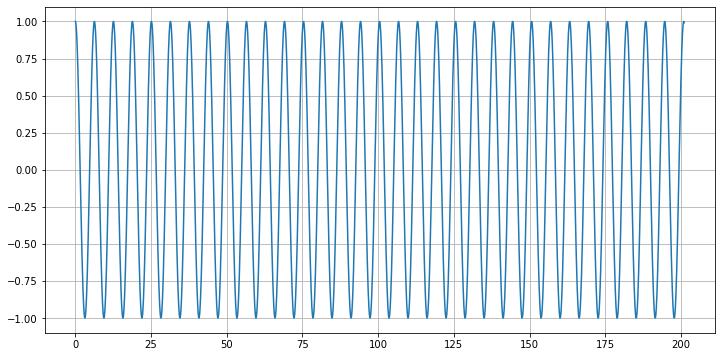

In [3]:
# Demo with the (undamped) mass-spring system

def f_mass_spring(t, u):
    return np.array([ u[1], -(k/M)*u[0] - (D/M)*u[1]])
M = 1.0
k = 1.0
D = 0.0
U_0 = [1.0, 0.0]
a = 0.0
periods =32
b = 2 * np.pi * periods
#nSteps = 1000  # Very Good?!
nSteps = 100*periods  # Good?
#nSteps = 20  # OK

# We need U_1, for now, get it with the Runge-Kutta method;
# this is overkill for accuracy, but since only one step is needed, the cost is negligible.
from numerical_methods_module import RungeKutta_system
h = (b-a)/nSteps
(t_1step, U_1step) = RungeKutta_system(f_mass_spring, a, a+h, U_0, n=1)
U_1 = U_1step[-1]
(t, U) = leap_frog(f_mass_spring, a, b, U_0, U_1, nSteps)

y = U[:,0]
#print(f"t={t}")
#print(f"y={y}")
figure(figsize=[12, 6])
plot(t, y)
grid(True)

---
This work is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)